In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from sklearn.linear_model import LinearRegression

from pandas.plotting import register_matplotlib_converters
from pylab import rcParams
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'
register_matplotlib_converters()
sns.set(style='whitegrid',palette='muted',font_scale=1.5)
rcParams['figure.figsize']=22,10

tf.random.set_seed(42)

from stldecompose import decompose

C:\Users\mert_\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data=pd.read_excel("DatabyDay-it-all-8years.xlsx")

In [3]:
data.head()

,Date,Truck
0,2011-01-01,0.0
1,2011-01-02,0.0
2,2011-01-03,0.0
3,2011-01-04,0.0
4,2011-01-05,1.0


In [4]:
data.index=data['Date']
data.drop(columns='Date',inplace=True)

In [5]:
data=data.resample('W').sum()
data.head(400)

,Truck
Date,
2011-01-02,0.0
2011-01-09,25.0
2011-01-16,19.0
2011-01-23,23.0
2011-01-30,25.0
...,...
2018-07-29,20.0
2018-08-05,9.0
2018-08-12,7.0


In [6]:
data=data.iloc[1:,:]
data.index=pd.to_datetime(data.index)

In [7]:
data.index

DatetimeIndex(['2011-01-09', '2011-01-16', '2011-01-23', '2011-01-30',
               '2011-02-06', '2011-02-13', '2011-02-20', '2011-02-27',
               '2011-03-06', '2011-03-13',
               ...
               '2018-09-02', '2018-09-09', '2018-09-16', '2018-09-23',
               '2018-09-30', '2018-10-07', '2018-10-14', '2018-10-21',
               '2018-10-28', '2018-11-04'],
              dtype='datetime64[ns]', name='Date', length=409, freq='W-SUN')

In [8]:
data['week']=data.index.week
data['month']=data.index.month
data['quarter']=data.index.quarter

<ipython-input-8-3af9b3e3f6f9>:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data['week']=data.index.week


In [9]:
decopm=decompose(data.Truck)

In [10]:
data['seasonal']=decopm.seasonal
data['trend']=decopm.trend

<AxesSubplot:xlabel='Date', ylabel='Truck'>

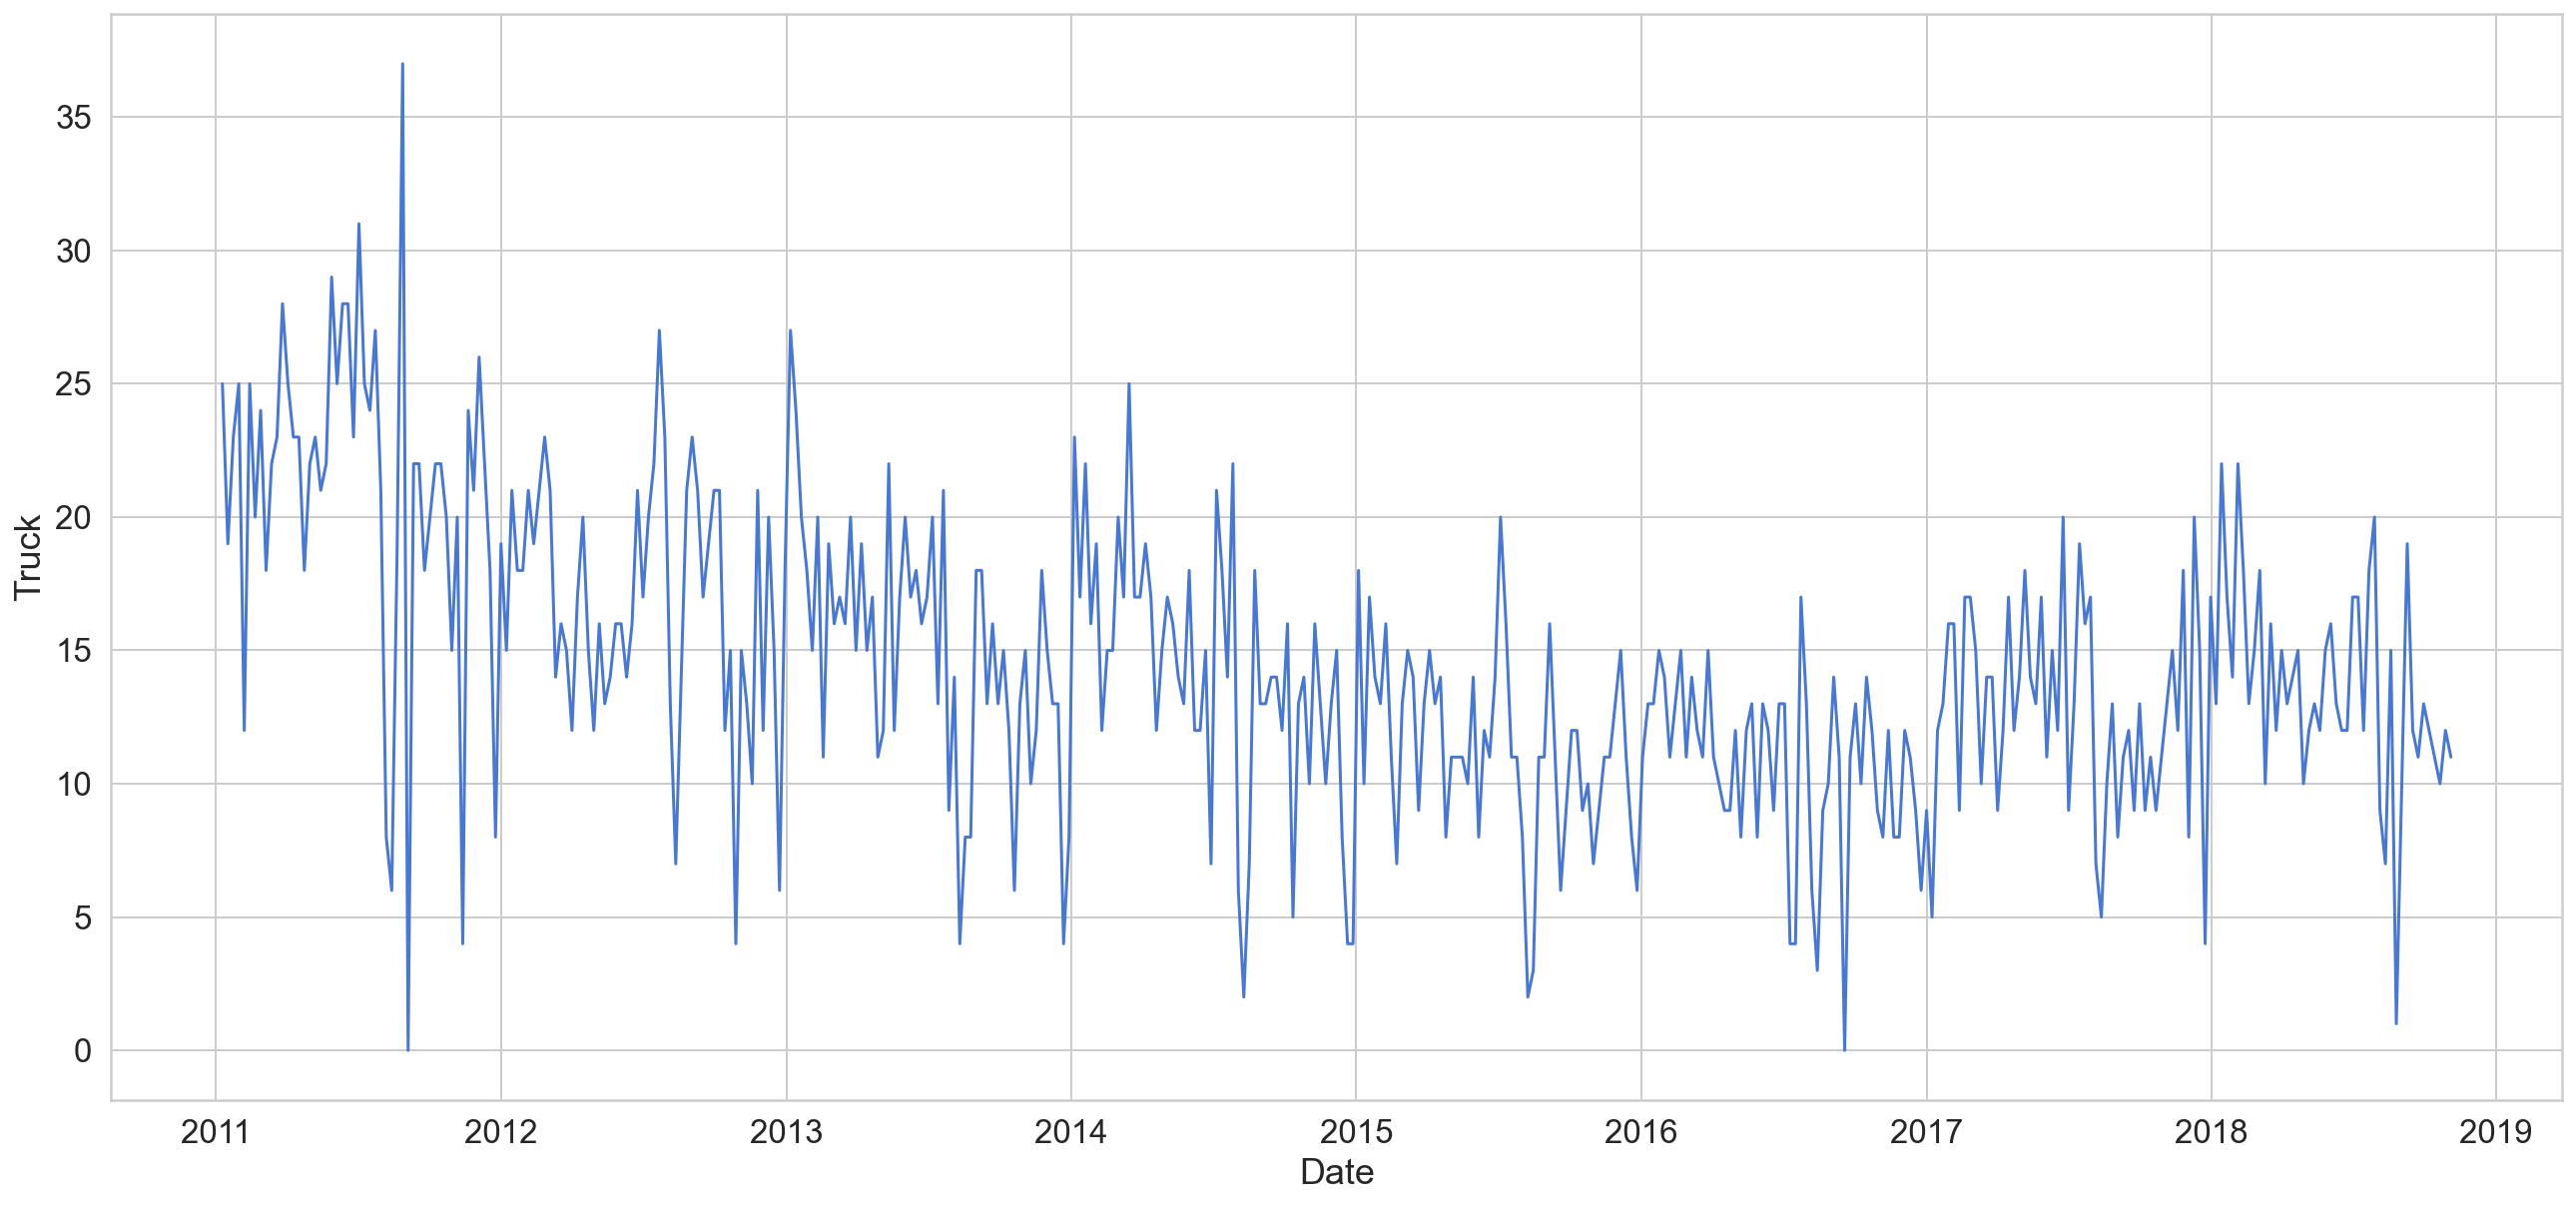

In [11]:
sns.lineplot(x=data.index,y='Truck',data=data)

<AxesSubplot:xlabel='Date', ylabel='Truck'>

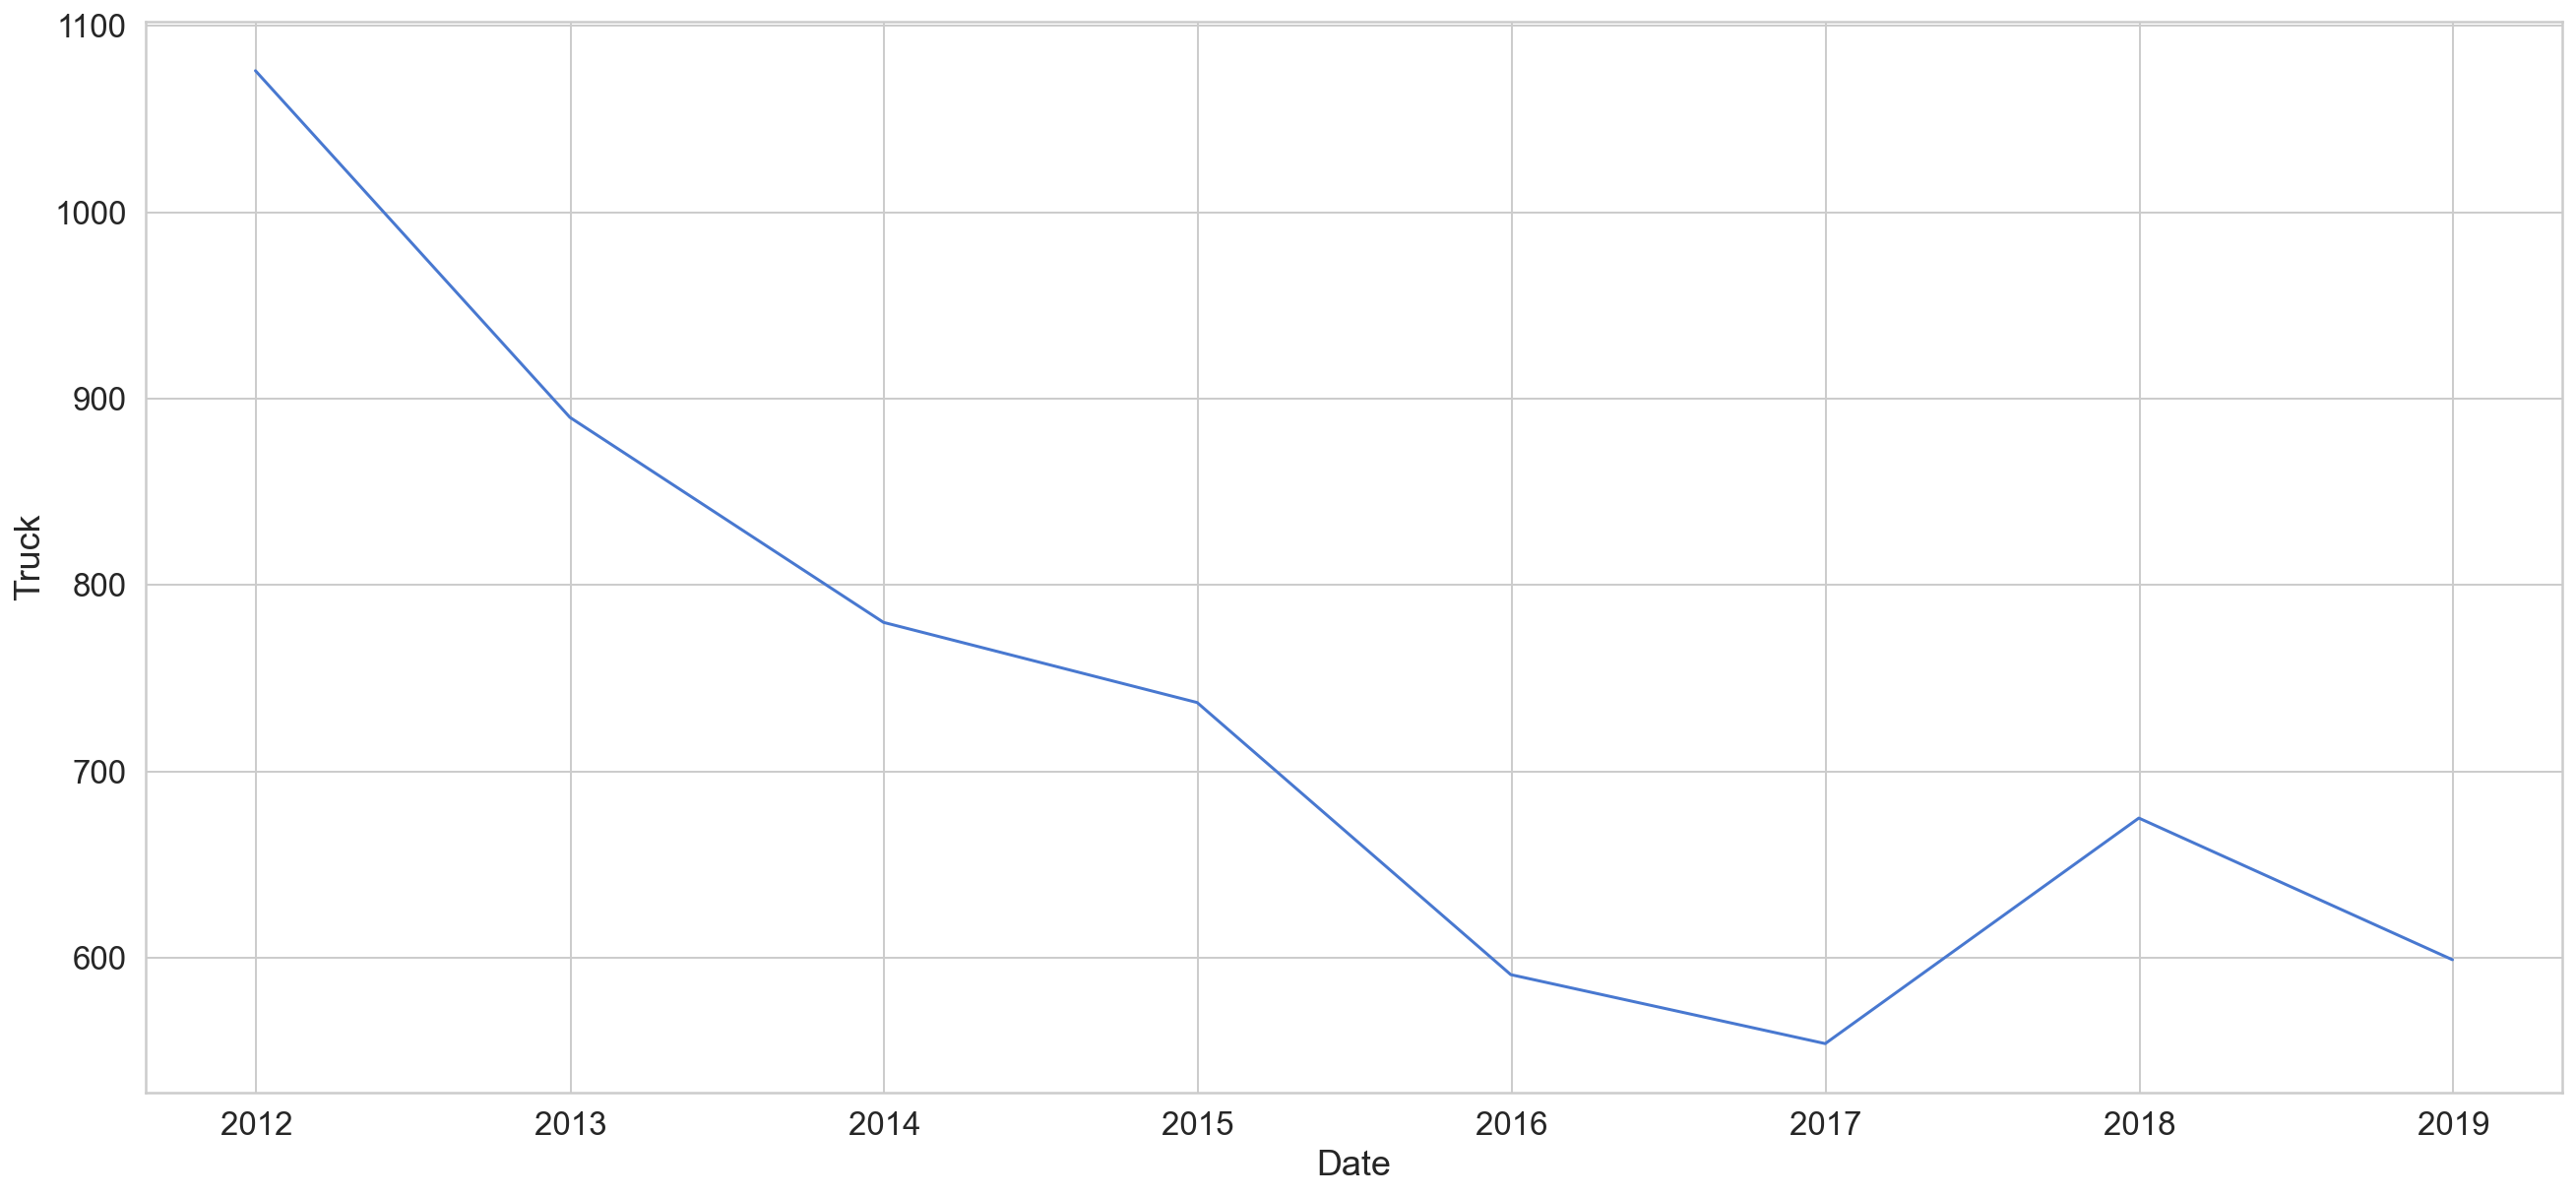

In [12]:
data_by_year=data.resample('Y').sum()
sns.lineplot(x=data_by_year.index,y='Truck',data=data_by_year)

<AxesSubplot:xlabel='month', ylabel='Truck'>

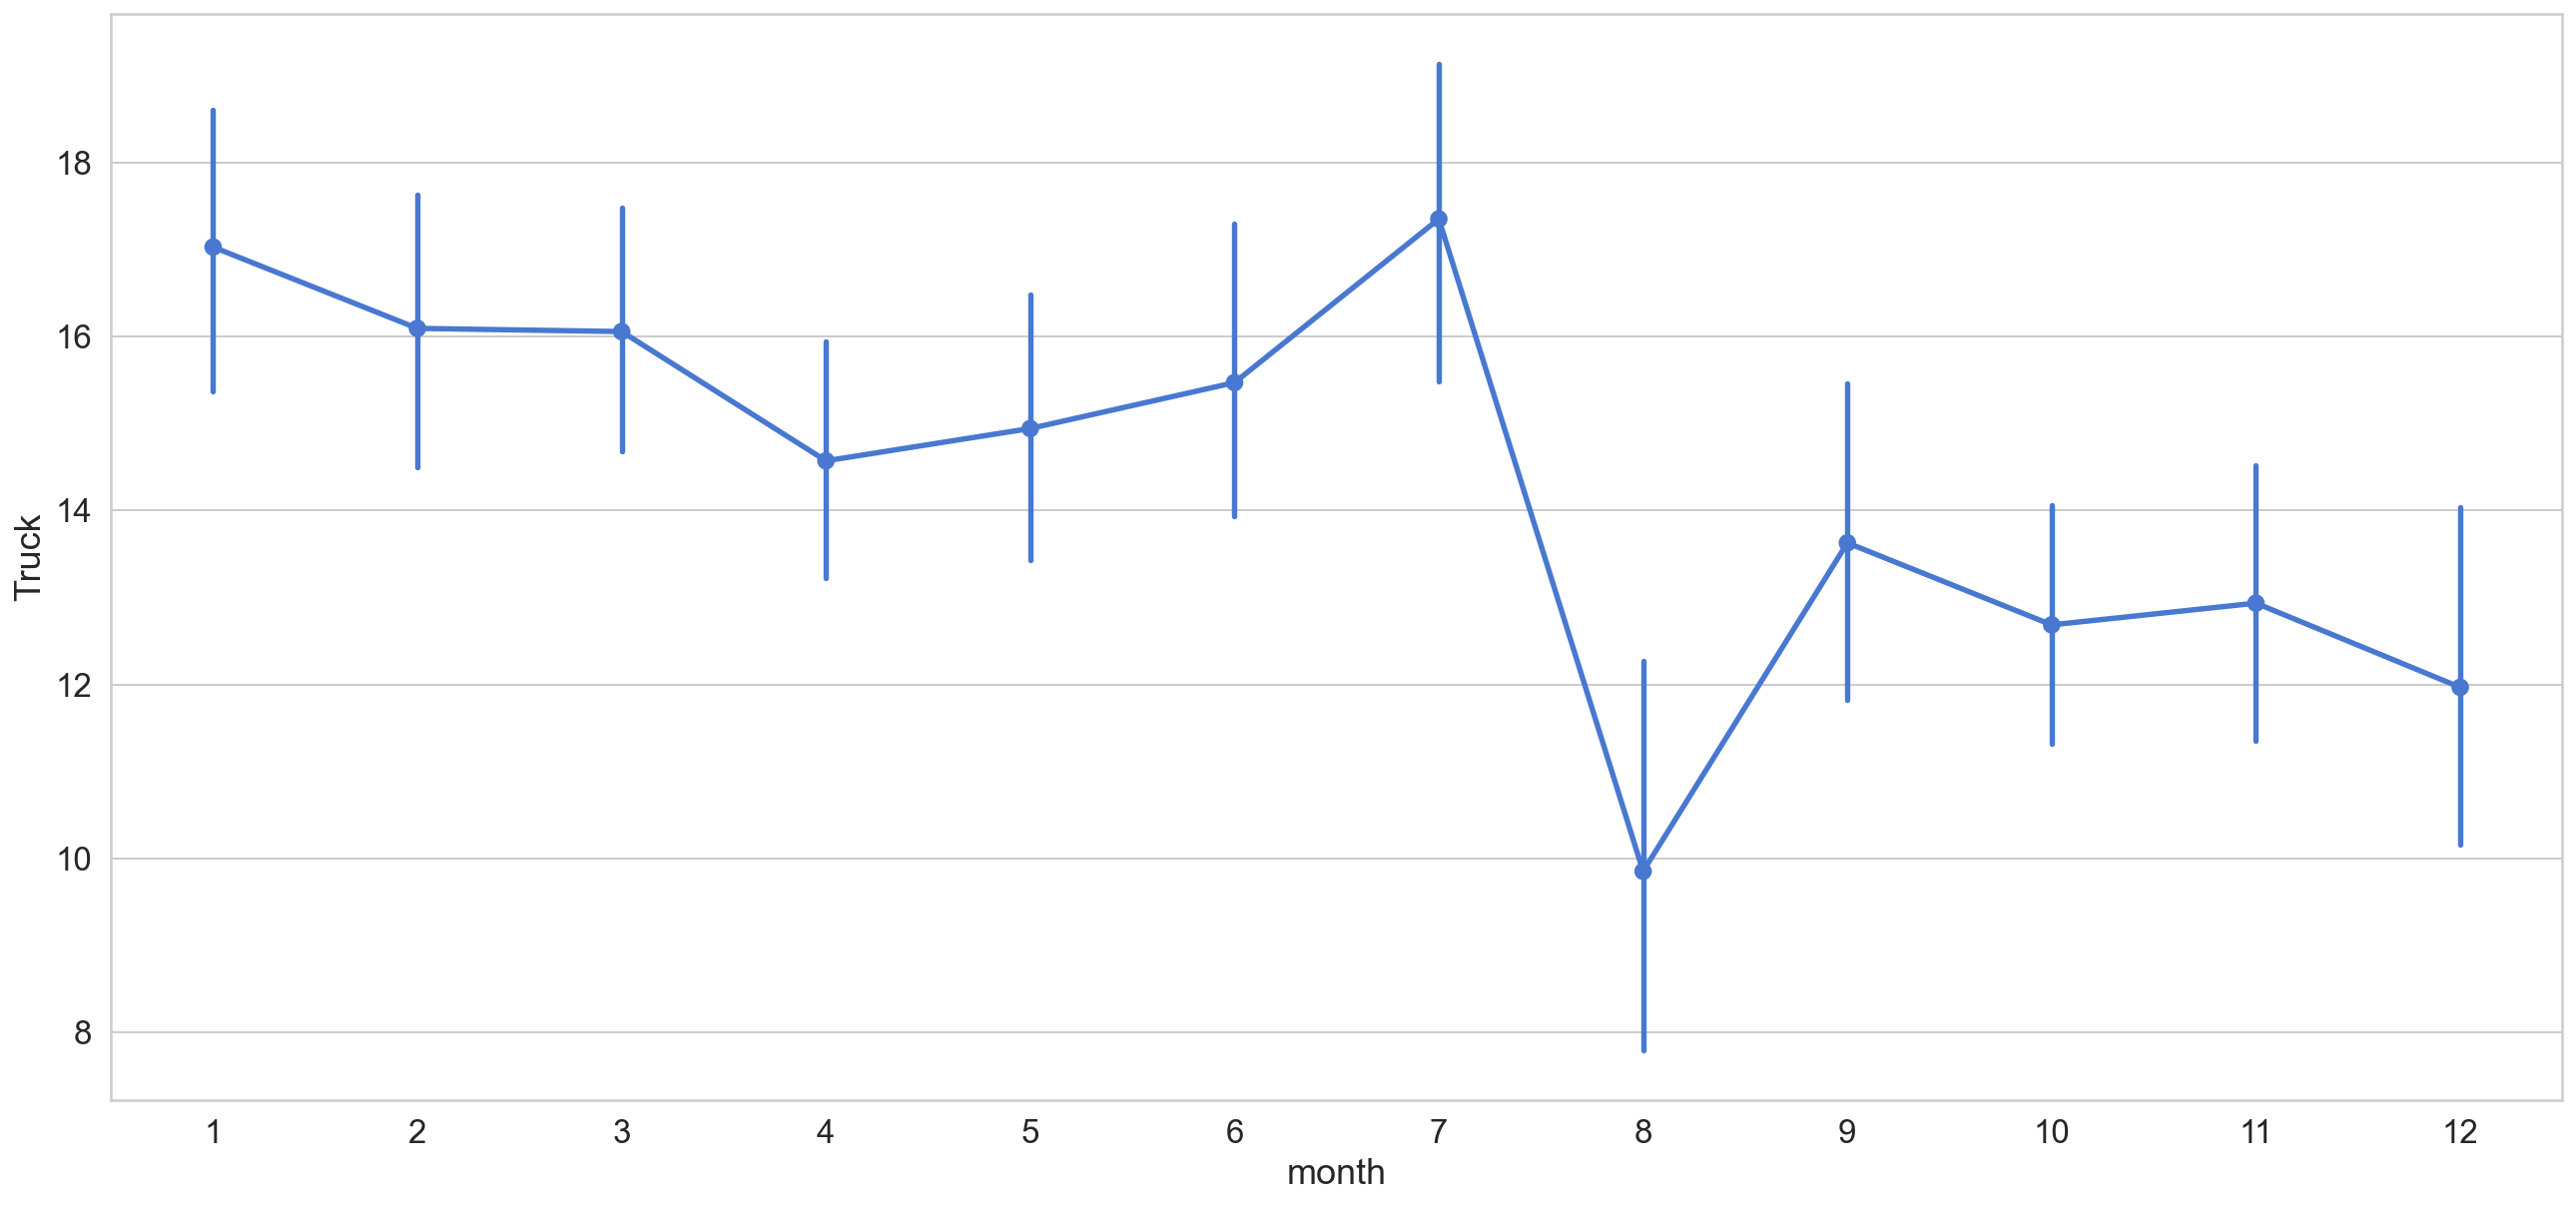

In [13]:
sns.pointplot(data=data,x='month',y='Truck')

<AxesSubplot:xlabel='week', ylabel='Truck'>

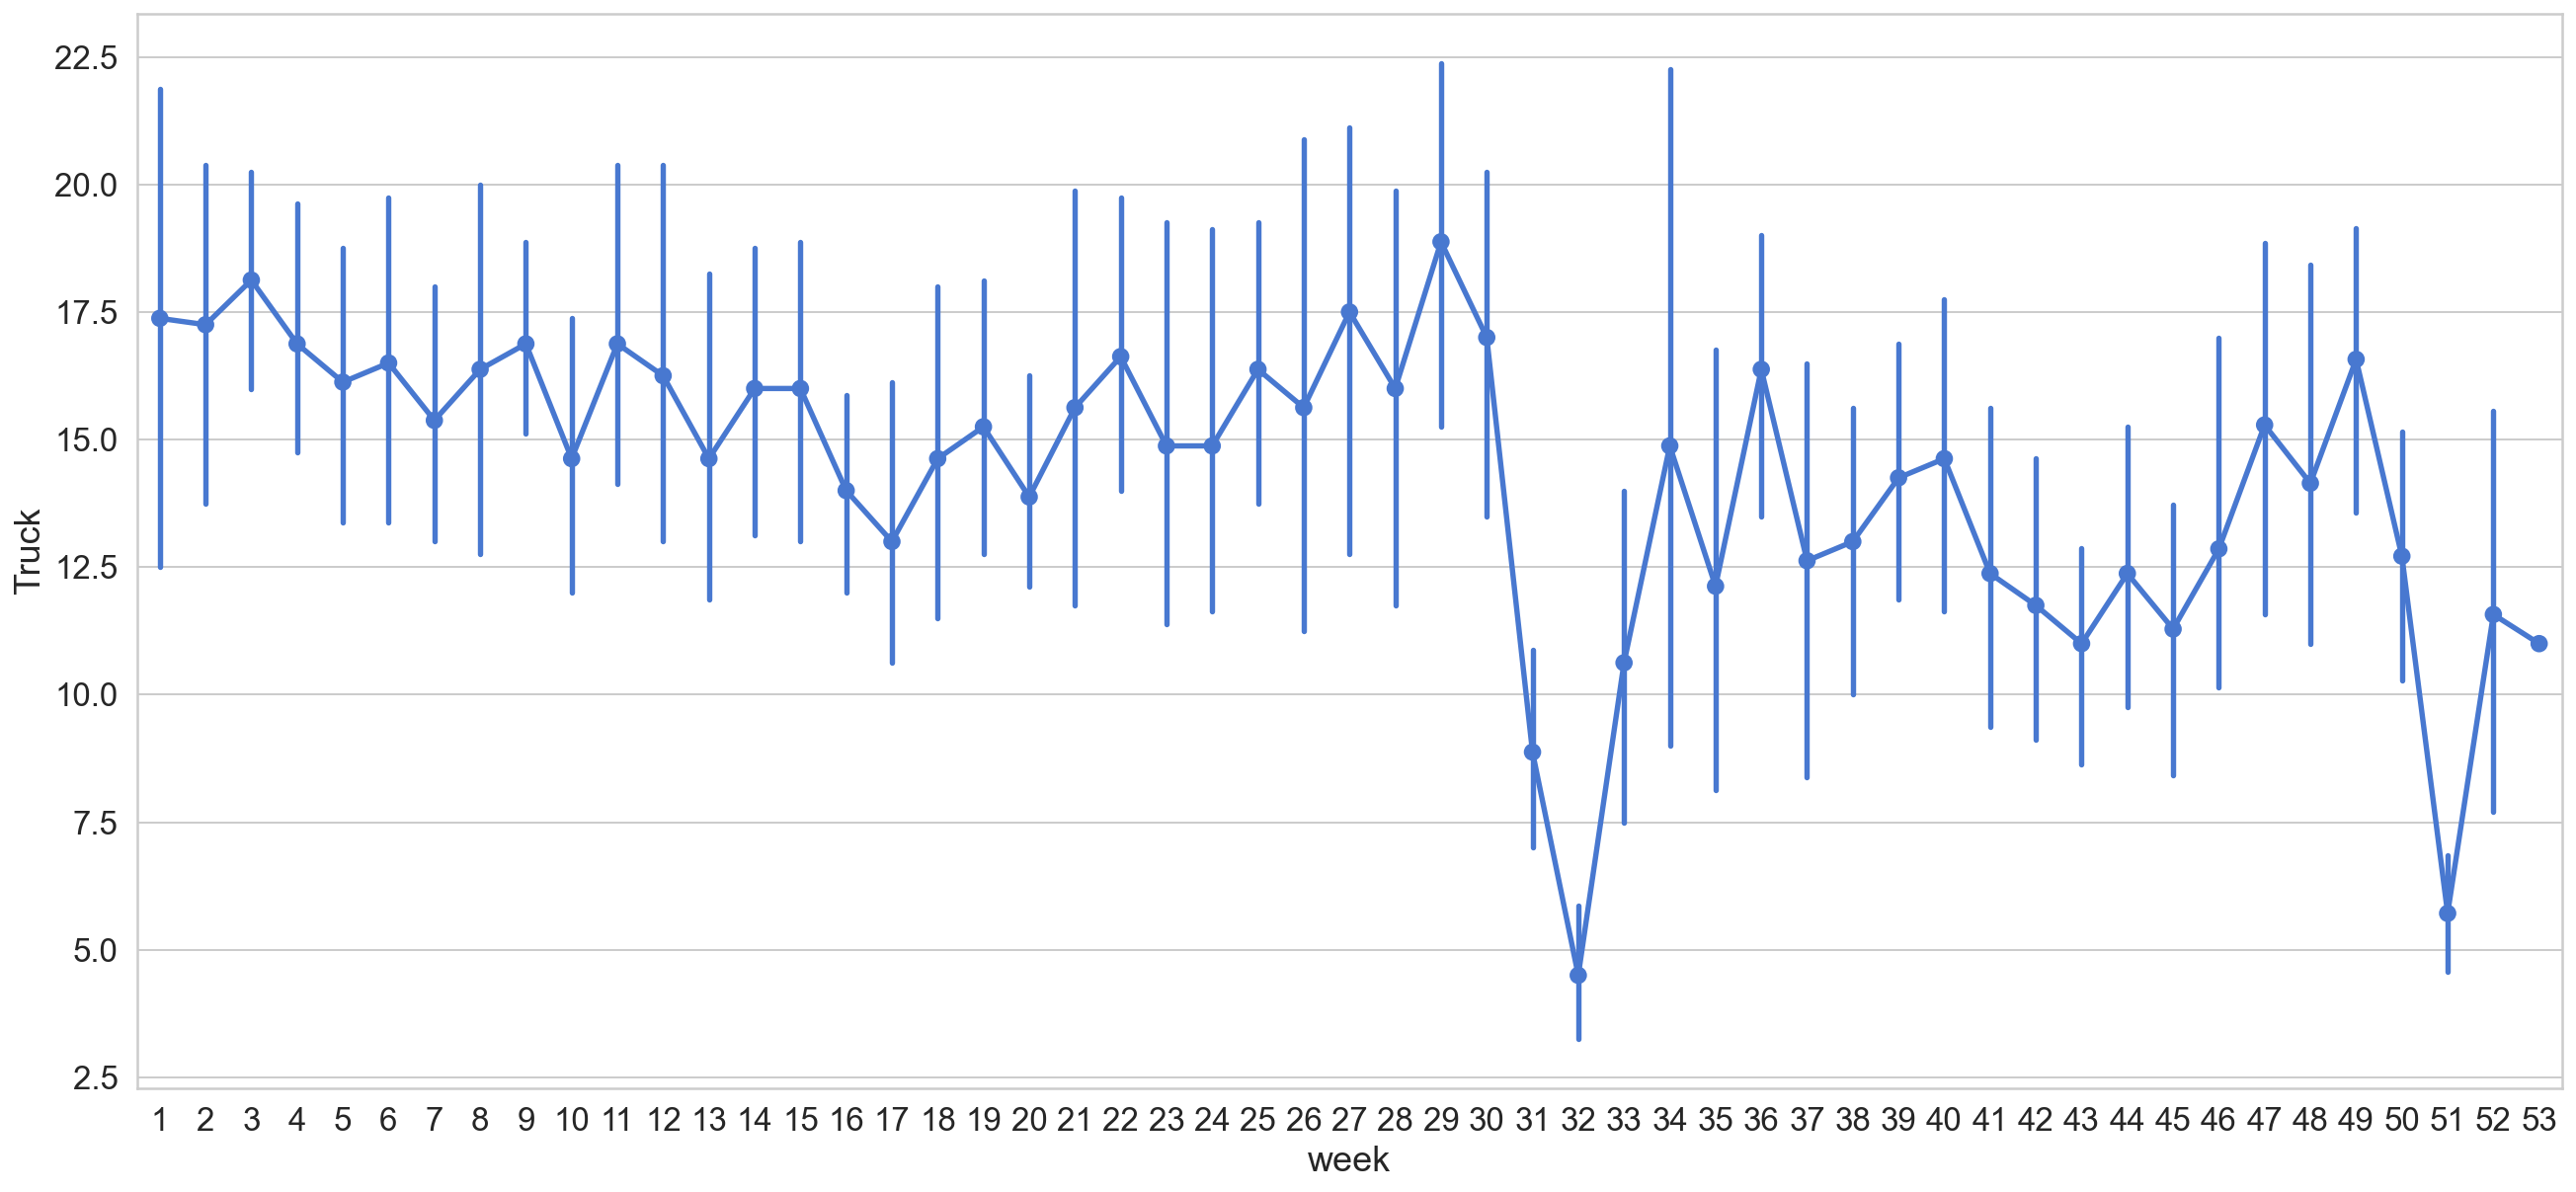

In [14]:
sns.pointplot(data=data,x='week',y='Truck')

In [15]:
scalerx = StandardScaler()
scalery = StandardScaler()

In [16]:
scalerx.fit(data.iloc[:,4:])
data.iloc[:,4:]=scalerx.transform(data.iloc[:,4:])

In [17]:
scalery.fit(data.iloc[:,0].values.reshape(-1,1))
data.iloc[:,0]= scalery.transform(data.iloc[:,0].values.reshape(-1,1))

In [18]:
data

,Truck,week,month,quarter,seasonal,trend
Date,,,,,,
2011-01-09,1.922848,1,1,1,0.411576,2.396285
2011-01-16,0.831321,2,1,1,0.780582,2.378802
2011-01-23,1.559005,3,1,1,0.664495,2.361318
2011-01-30,1.922848,4,1,1,0.548408,2.343834
2011-02-06,-0.442126,5,2,1,-0.052794,2.326351
...,...,...,...,...,...,...
2018-10-07,-0.442126,40,10,4,0.119688,-0.464905
2018-10-14,-0.624047,41,10,4,0.003161,-0.460148
2018-10-21,-0.805968,42,10,4,-0.355942,-0.455390


In [19]:
data.corr()

,Truck,week,month,quarter,seasonal,trend
Truck,1.000000,-0.282031,-0.272801,-0.259117,0.750506,0.583934
week,-0.282031,1.000000,0.954680,0.932034,-0.300508,-0.094818
month,-0.272801,0.954680,1.000000,0.970354,-0.294415,-0.087332
quarter,-0.259117,0.932034,0.970354,1.000000,-0.277564,-0.085173
seasonal,0.750506,-0.300508,-0.294415,-0.277564,1.000000,0.000768
trend,0.583934,-0.094818,-0.087332,-0.085173,0.000768,1.000000


In [20]:
split_time=int(len(data)*0.8)
y_train=data['Truck'][:split_time].values.reshape(-1,1)
y_test=data['Truck'][split_time:].values.reshape(-1,1)
x_train=data.iloc[:split_time,1:].values
x_test=data.iloc[split_time:,1:].values

In [21]:
x_test

array([[ 1.50000000e+01,  4.00000000e+00,  2.00000000e+00,
         1.26382532e+00, -8.04351656e-01],
       [ 1.60000000e+01,  4.00000000e+00,  2.00000000e+00,
         4.80165034e-02, -8.00486707e-01],
       [ 1.70000000e+01,  4.00000000e+00,  2.00000000e+00,
         5.29989499e-01, -7.96569711e-01],
       [ 1.80000000e+01,  5.00000000e+00,  2.00000000e+00,
         1.49705485e+00, -7.92652715e-01],
       [ 1.90000000e+01,  5.00000000e+00,  2.00000000e+00,
         5.23750770e-01, -7.88735719e-01],
       [ 2.00000000e+01,  5.00000000e+00,  2.00000000e+00,
         2.78085225e-01, -7.84818723e-01],
       [ 2.10000000e+01,  5.00000000e+00,  2.00000000e+00,
         1.24510406e+00, -7.80843307e-01],
       [ 2.20000000e+01,  6.00000000e+00,  2.00000000e+00,
        -2.13338910e-01, -7.76867891e-01],
       [ 2.30000000e+01,  6.00000000e+00,  2.00000000e+00,
         7.53679921e-01, -7.72892476e-01],
       [ 2.40000000e+01,  6.00000000e+00,  2.00000000e+00,
         2.28754934e-02

In [22]:
y_train.shape,x_train.shape,y_test.shape,x_test.shape

((327, 1), (327, 5), (82, 1), (82, 5))

In [23]:
model=Sequential()
model.add(Dense(32,input_shape=(x_train.shape[1],)))
model.add(Dense(16,activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2))

In [24]:
history=model.fit(x_train,y_train,epochs=50,validation_data=(x_test,y_test),batch_size=26,shuffle=False)

Epoch 1/50
13/13 [==============================] - 0s 12ms/step - loss: 2.6962 - val_loss: 0.4782
Epoch 2/50
13/13 [==============================] - 0s 3ms/step - loss: 0.8530 - val_loss: 0.4817
Epoch 3/50
13/13 [==============================] - 0s 3ms/step - loss: 0.7168 - val_loss: 0.5280
Epoch 4/50
13/13 [==============================] - 0s 3ms/step - loss: 0.7708 - val_loss: 0.8424
Epoch 5/50
13/13 [==============================] - 0s 2ms/step - loss: 0.6277 - val_loss: 0.3402
Epoch 6/50
13/13 [==============================] - 0s 3ms/step - loss: 0.5007 - val_loss: 0.5628
Epoch 7/50
13/13 [==============================] - 0s 3ms/step - loss: 0.7503 - val_loss: 0.5317
Epoch 8/50
13/13 [==============================] - 0s 2ms/step - loss: 0.7668 - val_loss: 0.5739
Epoch 9/50
13/13 [==============================] - 0s 3ms/step - loss: 0.5782 - val_loss: 0.5409
Epoch 10/50
13/13 [==============================] - 0s 3ms/step - loss: 0.4419 - val_loss: 0.3704
Epoch 11/50
13/13 

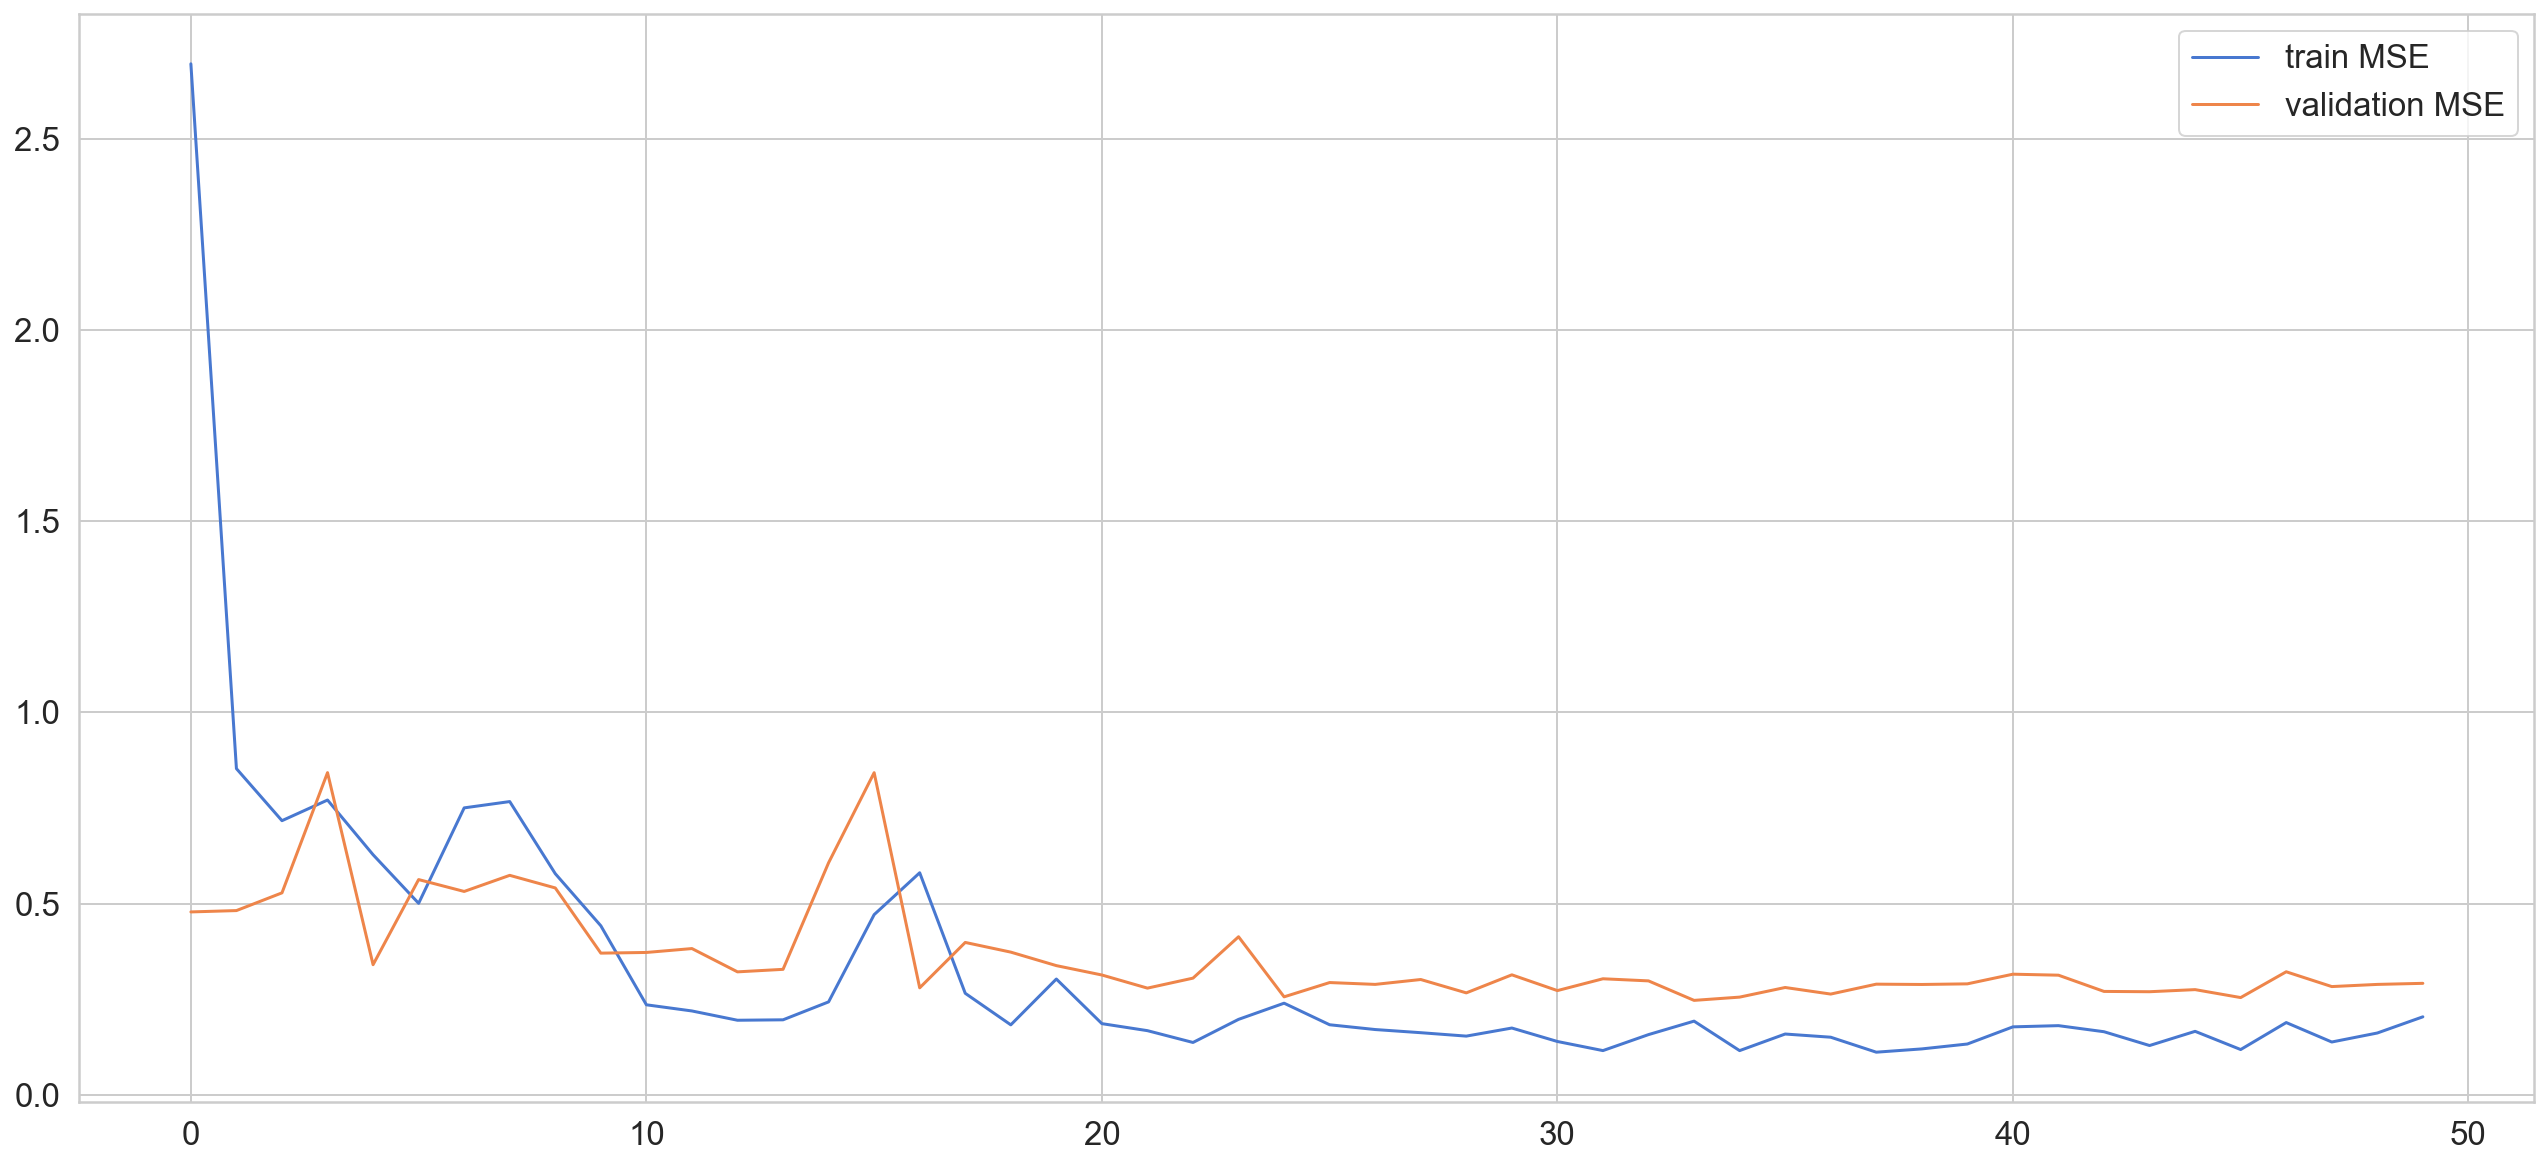

In [25]:
plt.plot(history.history['loss'],label='train MSE')
plt.plot(history.history['val_loss'],label='validation MSE')
plt.legend()

In [26]:
y_pred=model.predict(x_test)

In [27]:
y_train_inv=scalery.inverse_transform(y_train)
y_test_inv=scalery.inverse_transform(y_test)
y_pred_inv=scalery.inverse_transform(y_pred)

In [28]:
MAE=mean_absolute_error(y_test_inv,y_pred_inv)
RMSE=np.sqrt(mean_absolute_error(y_test_inv,y_pred_inv))

In [29]:
r2_score(y_test_inv,y_pred_inv)

0.5307561519347992

In [30]:
evaluate=pd.DataFrame([MAE,RMSE],columns=['Value'],index=['MAE','RMSE'])
evaluate

,Value
MAE,1.601919
RMSE,1.265669


In [31]:
next_month1=np.array([[45.        ,  11.        ,  4.        ,  -0.22523679, -0.44587695]])
yhat = model.predict(next_month1, verbose=0)
yhat_inv=scalery.inverse_transform(yhat)
yhat_inv

array([[12.768922]], dtype=float32)

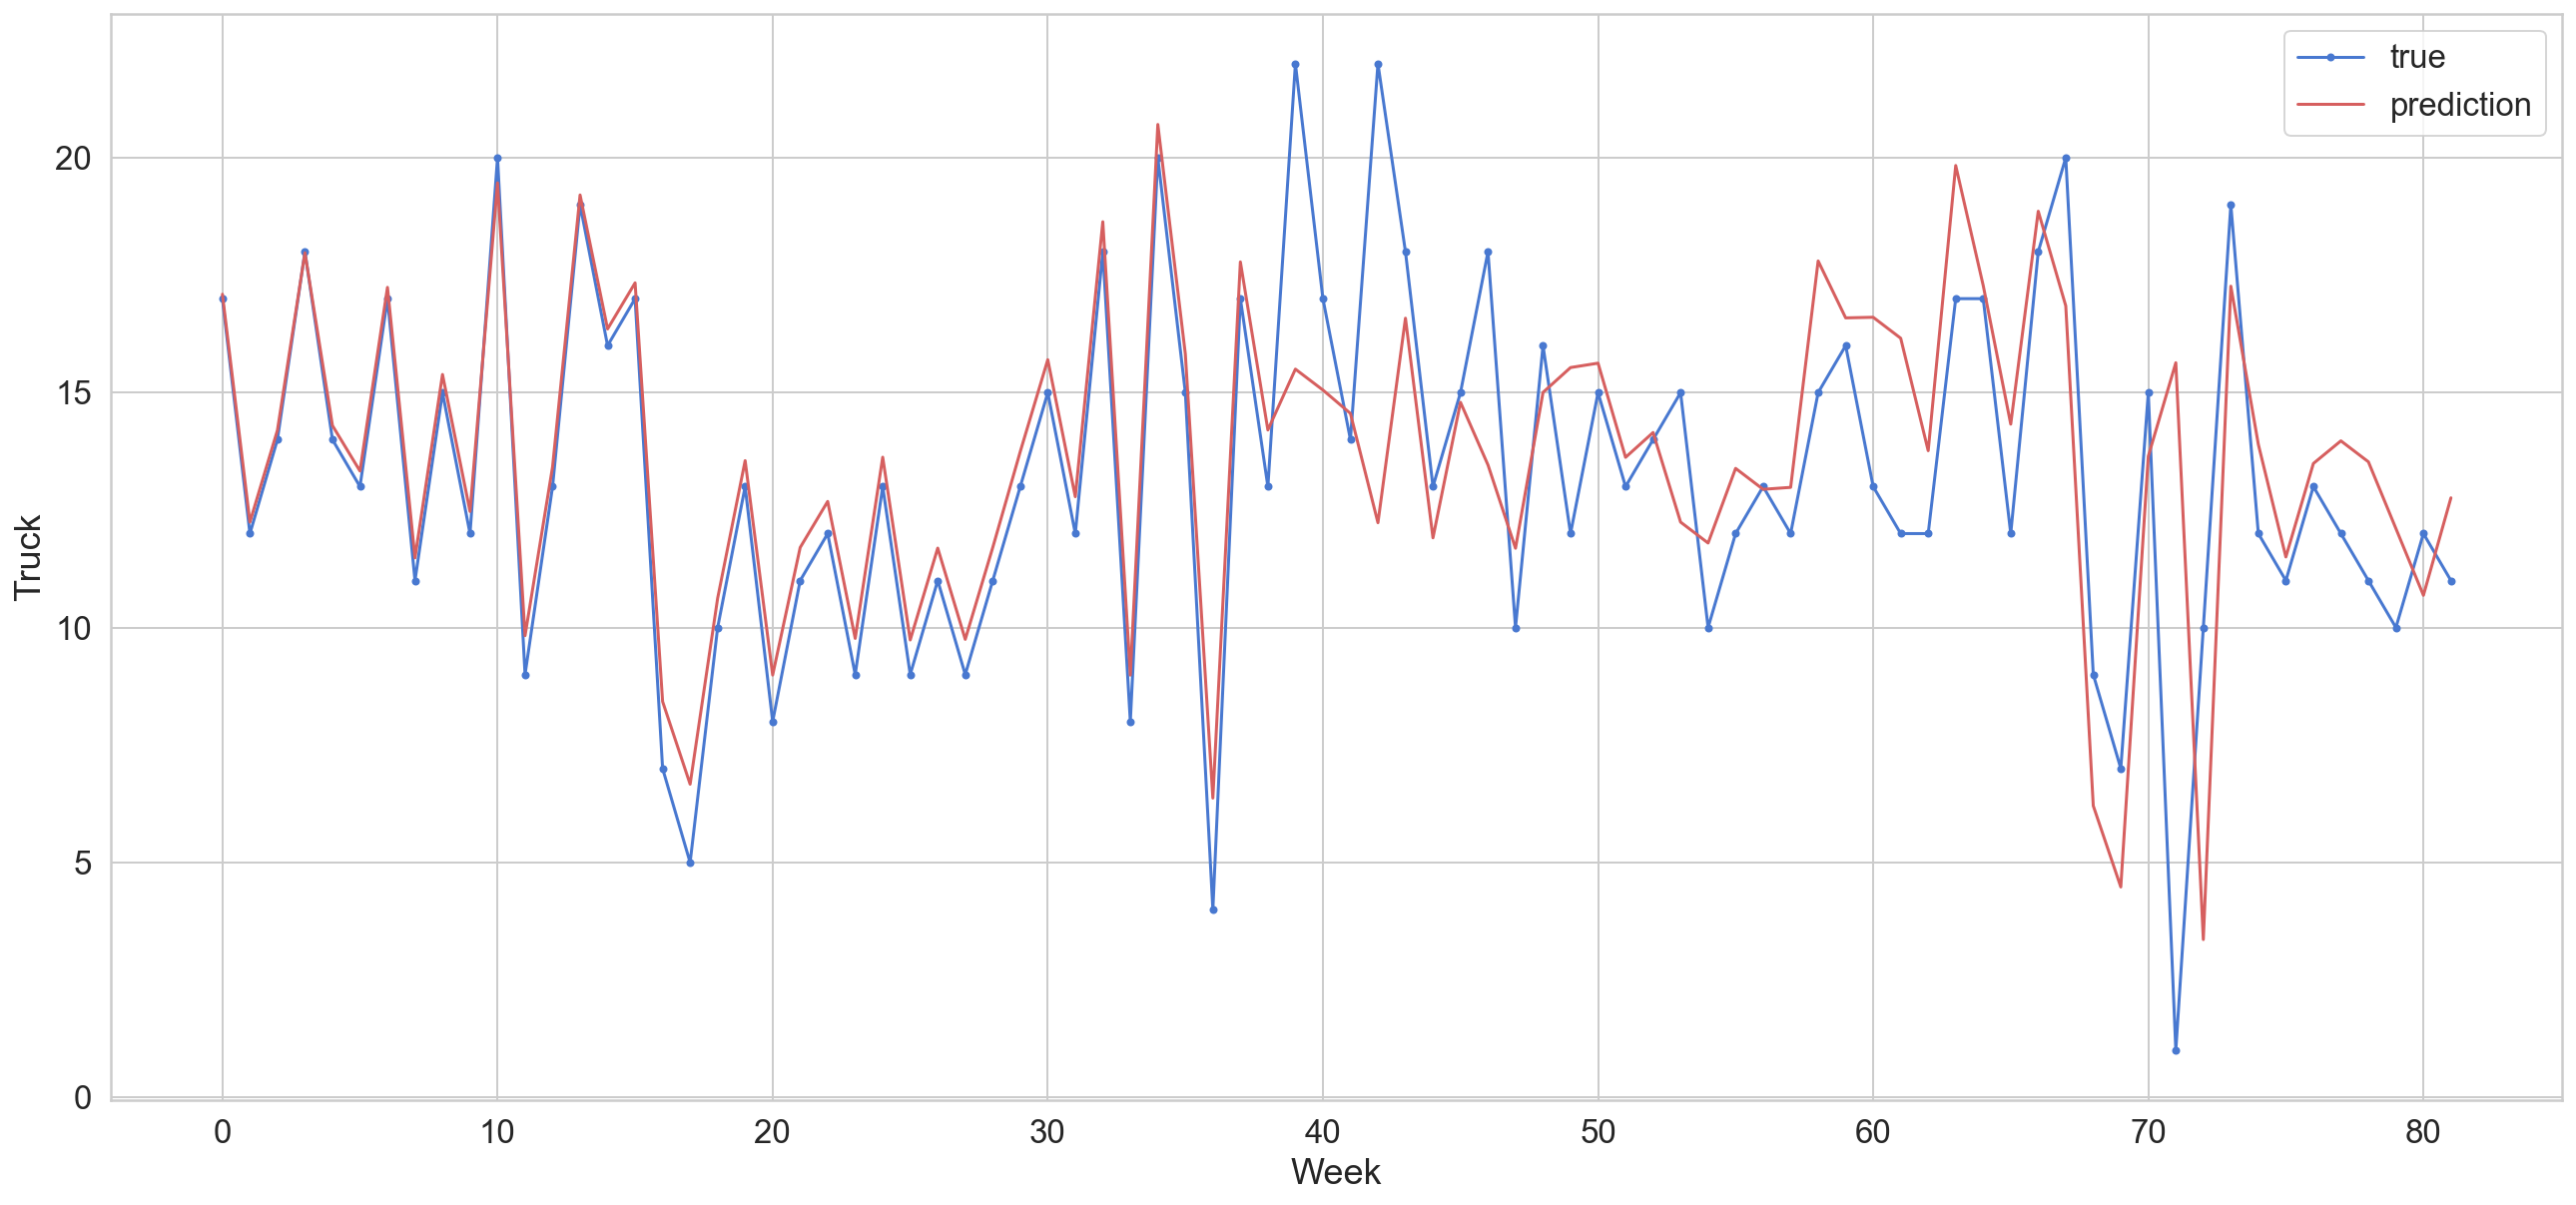

In [32]:
plt.plot(y_test_inv, marker='.', label="true")
plt.plot(y_pred_inv, 'r', label="prediction")
plt.ylabel('Truck')
plt.xlabel('Week')
plt.legend()
plt.show();

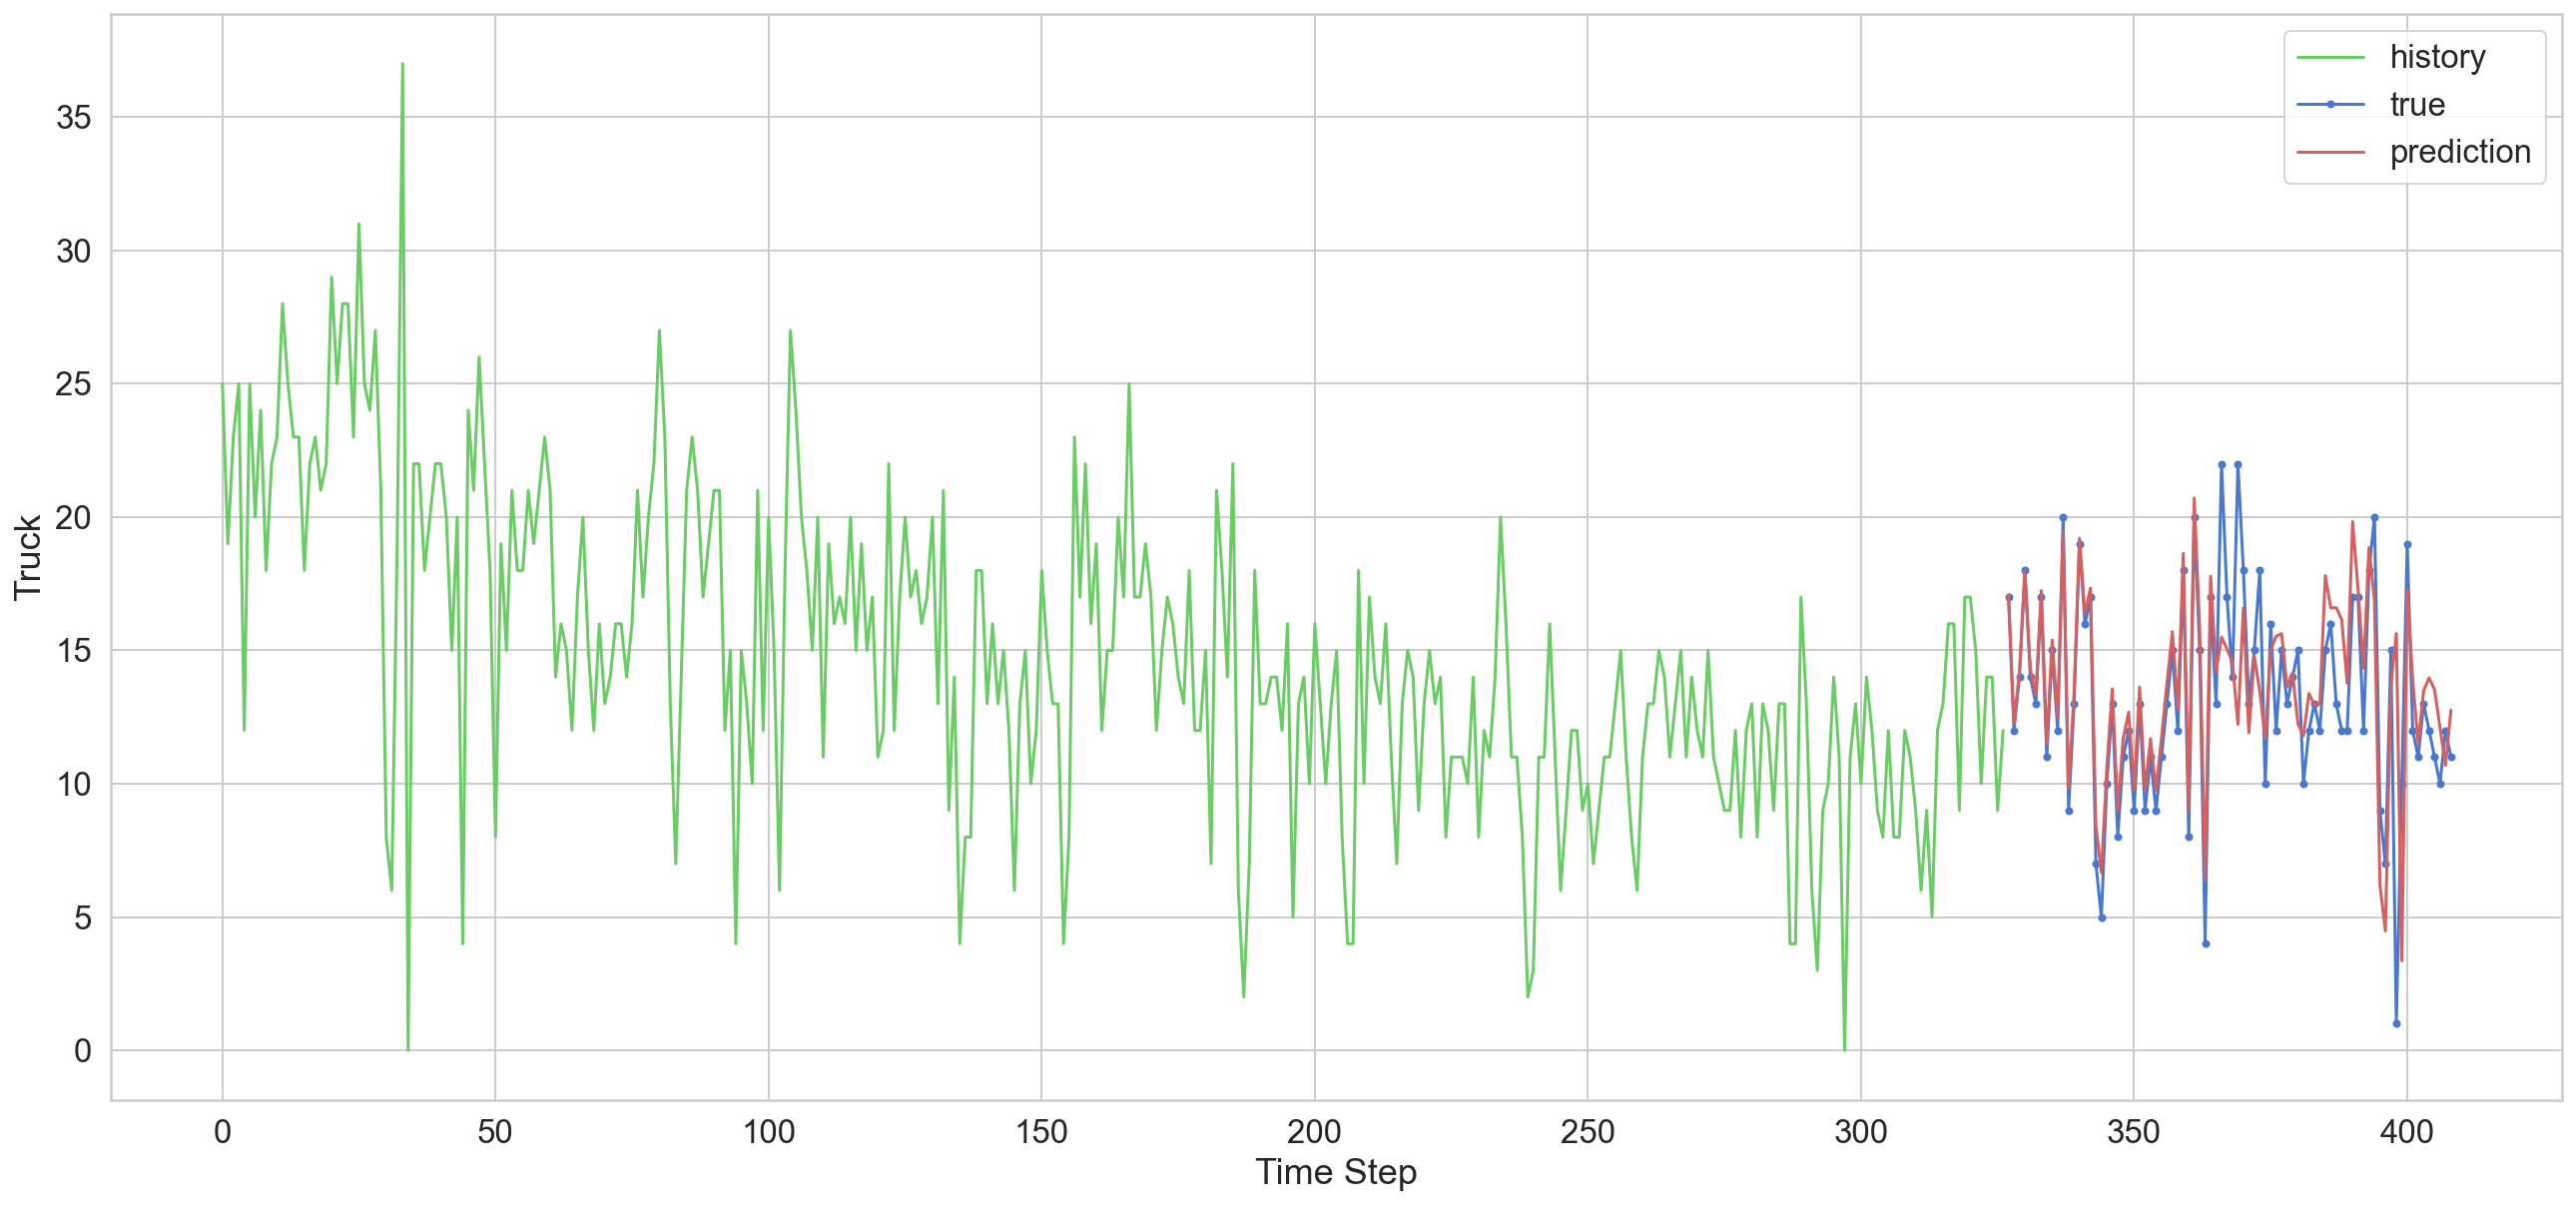

In [33]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, 'r', label="prediction")
plt.ylabel('Truck')
plt.xlabel('Time Step')
plt.legend()
plt.show();